In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from collections import defaultdict
import pandas as pd
from nltk import word_tokenize
import re
import numpy as np
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange
import transformers

In [3]:
target_length_range = (5, 10)

In [4]:
# regex implementation here differs slightly from the one used to do the efficient search;
# prepare to filter the results so we know we are consistent
with open("final_word_re.txt") as f:
    word_re = re.compile(f.read(), re.IGNORECASE)

In [5]:
!wc -l matches.opensubtitles-en.txt

8991155 matches.opensubtitles-en.txt


In [6]:
matches = defaultdict(list)

with open("matches.opensubtitles-en.txt", "r") as f:
    for line in tqdm(f, total=8991155):
        word, sent = line.strip().split("\t", 1)
        toks = word_tokenize(sent)
        if len(toks) >= target_length_range[0] and len(toks) <= target_length_range[1]:
            matches[word].append(sent)

  0%|          | 0/8991155 [00:00<?, ?it/s]

In [7]:
matches = {k: list(set(ms)) for k, ms in matches.items()}

In [8]:
# Preprocess sentences
def preprocess_sentence(sentence, target_word):
    # make sure target word appears with preceding space
    sentence = re.sub(rf"(.\b)(?={target_word})", lambda x: " " if x.group(1) in [" ", "-"] else x.group(1) + " ", sentence)

    if not word_re.match(target_word):
        return None

    return sentence

In [9]:
new_matches = {}
for k, sentences in matches.items():
    new_matches_k = []
    for sentence in sentences:
        new_sentence = preprocess_sentence(sentence, k)
        if new_sentence is not None:
            new_matches_k.append(new_sentence)
    new_matches[k] = new_matches_k

In [10]:
# sort by length so that we get efficient padding/batching
matches = {k: sorted(sentences, key=lambda x: -len(x)) for k, sentences in new_matches.items()}

## Surprisal evaluation

In [17]:
# model = transformers.AutoModelForCausalLM.from_pretrained("gpt2-xl").to("cuda")
# tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2-xl")

# tokenizer.pad_token = tokenizer.eos_token

import minicons.scorer
scorer = minicons.scorer.IncrementalLMScorer("gpt2", device="cuda")

In [16]:
from typing import Iterable, List, Tuple, Union


def compute_surprisal_entropy(self,
    batch: Iterable,
    rank: bool = False,
    prob: bool = False,
    base_two: bool = False,
    return_tensors: bool = False,
) -> Union[Tuple[List[float], List[float]], List[float]]:
    """
    Primary computational method that processes a batch of prepared sentences and returns per-token scores for each sentence. By default, returns log-probabilities.

    :param ``Iterable`` batch: batched input as processed by ``prepare_text`` or ``prime_text``.
    :param ``bool`` rank: whether the model should also return ranks per word (based on the conditional log-probability of the word in context).
    :param ``bool`` prob: whether the model should return probabilities instead of log-probabilities. Can only be `True` when `base_two` is `False`.
    :param ``bool`` base_two: whether the base of the log should be 2 (usually preferred when reporting results in bits). Can only be `True` when `prob` is `False`.
    :param ``bool`` return_tensors: whether the model should return scores as a list of tensors instead of a list of lists. This is important in some other convenient methods used in the package.

    :return: Either a tuple of lists, each containing probabilities and ranks per token in each sentence passed in the input.
    :rtype: ``Union[Tuple[List[float], List[int]], List[float]]``
    """
    assert not (
        base_two and prob
    ), "cannot both use base (which is for a log), and a probability measure at the same time!"

    batch = self.prepare_text(batch)

    encoded, offsets = batch
    if self.device != "auto":
        encoded = encoded.to(self.device)

    # ids = [
    #     [i for i in instance if i != self.tokenizer.pad_token_id]
    #     for instance in encoded["input_ids"].tolist()
    # ]
    ids = [
        [i for i, am in zip(instance, attention_mask) if am != 0]
        for instance, attention_mask in zip(
            encoded["input_ids"].tolist(), encoded["attention_mask"].tolist()
        )
    ]

    ## Ignore the probabilities of the first token.
    effective_ids = [id[1:] for id in ids]

    with torch.no_grad():
        logits = self.model(**encoded).logits.detach()

    # logits[:, :, self.tokenizer.pad_token_id] = float("-inf")

    logits = logits.split([1] * len(offsets))

    ## Set up storage variables
    surprisals, entropies = [], []

    for logit, idx, offset in zip(logits, effective_ids, offsets):
        length = len(idx)
        logit = logit.squeeze(0)[torch.arange(offset, length),]

        logprob_distribution = logit - logit.logsumexp(1).unsqueeze(1)
        entropy = (-1.0 * (logprob_distribution * logprob_distribution.exp()).sum(1))

        query_ids = idx[offset:]
        surprisal = (
            logprob_distribution[torch.arange(length - offset), query_ids]
            / torch.tensor(2).log()
        )

        surprisals.append(surprisal)
        entropies.append(entropy)

    indices = [
        [i for i, am in zip(instance, attention_mask) if am != 0]
        for instance, attention_mask in zip(
            batch[0]["input_ids"].tolist(),
            batch[0]["attention_mask"].tolist(),
        )
    ]
    tokens = [self.tokenizer.convert_ids_to_tokens(idx) for idx in indices]
    assert len(tokens) == len(surprisals)

    return tokens, surprisals, entropies

In [18]:
batch_size = 64
results = []

# {"filth": matches["filth"]}.items()
for target_word, sents in tqdm(matches.items(), unit="target word"):
    sent_ids = np.arange(len(sents))
    print(target_word, scorer.tokenizer(" " + target_word).input_ids)
    target_word_tokens = scorer.tokenizer.convert_ids_to_tokens(scorer.tokenizer(" " + target_word)["input_ids"])

    for batch_cursor in trange(0, len(sents), batch_size, unit="batch", leave=False):
        sent_ids_batch = sent_ids[batch_cursor:batch_cursor + batch_size]
        sents_batch = sents[batch_cursor:batch_cursor + batch_size]

        batch_tokens, batch_surprisals, batch_entropies = compute_surprisal_entropy(scorer, sents_batch)

        found_mask = np.zeros((len(sents_batch), 1), dtype=bool)
        sentence_target_values = np.zeros((len(sents_batch), 2))
        for i, sent in enumerate(sents_batch):
            for j in range(len(batch_tokens[i])):
                if batch_tokens[i][j:j+len(target_word_tokens)] == target_word_tokens:
                    sentence_target_values[i, 0] = batch_surprisals[i][j - 1:j - 1 +len(target_word_tokens)].sum().item()
                    sentence_target_values[i, 1] = batch_entropies[i][j - 1].item()
                    found_mask[i] = True

        results.append(pd.DataFrame({"target_word": target_word, "sentence_idx": sent_ids_batch, "sentence": sents_batch,
                                     "found": found_mask.flatten(), "surprisal": sentence_target_values[:, 0], "entropy": sentence_target_values[:, 1]}))

  0%|          | 0/132 [00:00<?, ?target word/s]

girl [2576]


  0%|          | 0/1482 [00:00<?, ?batch/s]

honey [12498]


  0%|          | 0/451 [00:00<?, ?batch/s]

style [3918]


  0%|          | 0/145 [00:00<?, ?batch/s]

floor [4314]


  0%|          | 0/345 [00:00<?, ?batch/s]

water [1660]


  0%|          | 0/695 [00:00<?, ?batch/s]

wrong [2642]


  0%|          | 0/955 [00:00<?, ?batch/s]

deep [2769]


  0%|          | 0/82 [00:00<?, ?batch/s]

baby [5156]


  0%|          | 0/1198 [00:00<?, ?batch/s]

mean [1612]


  0%|          | 0/562 [00:00<?, ?batch/s]

love [1842]


  0%|          | 0/1307 [00:00<?, ?batch/s]

film [2646]


  0%|          | 0/199 [00:00<?, ?batch/s]

smoke [7523]


  0%|          | 0/132 [00:00<?, ?batch/s]

dream [4320]


  0%|          | 0/359 [00:00<?, ?batch/s]

door [3420]


  0%|          | 0/861 [00:00<?, ?batch/s]

tree [5509]


  0%|          | 0/218 [00:00<?, ?batch/s]

blood [2910]


  0%|          | 0/433 [00:00<?, ?batch/s]

wish [4601]


  0%|          | 0/158 [00:00<?, ?batch/s]

duty [7077]


  0%|          | 0/161 [00:00<?, ?batch/s]

clean [3424]


  0%|          | 0/196 [00:00<?, ?batch/s]

money [1637]


  0%|          | 0/1831 [00:00<?, ?batch/s]

wheel [7825]


  0%|          | 0/73 [00:00<?, ?batch/s]

drug [2563]


  0%|          | 0/41 [00:00<?, ?batch/s]

table [3084]


  0%|          | 0/335 [00:00<?, ?batch/s]

host [2583]


  0%|          | 0/32 [00:00<?, ?batch/s]

club [3430]


  0%|          | 0/233 [00:00<?, ?batch/s]

filth [1226, 400]


  0%|          | 0/15 [00:00<?, ?batch/s]

city [1748]


  0%|          | 0/356 [00:00<?, ?batch/s]

truth [3872]


  0%|          | 0/541 [00:00<?, ?batch/s]

gift [6979]


  0%|          | 0/180 [00:00<?, ?batch/s]

price [2756]


  0%|          | 0/140 [00:00<?, ?batch/s]

chief [4039]


  0%|          | 0/128 [00:00<?, ?batch/s]

pity [26246]


  0%|          | 0/41 [00:00<?, ?batch/s]

goal [3061]


  0%|          | 0/66 [00:00<?, ?batch/s]

real [1103]


  0%|          | 0/357 [00:00<?, ?batch/s]

evil [6181]


  0%|          | 0/129 [00:00<?, ?batch/s]

board [3096]


  0%|          | 0/187 [00:00<?, ?batch/s]

fence [13990]


  0%|          | 0/54 [00:00<?, ?batch/s]

snow [6729]


  0%|          | 0/76 [00:00<?, ?batch/s]

plane [6614]


  0%|          | 0/199 [00:00<?, ?batch/s]

green [4077]


  0%|          | 0/87 [00:00<?, ?batch/s]

crew [5462]


  0%|          | 0/101 [00:00<?, ?batch/s]

trail [8025]


  0%|          | 0/52 [00:00<?, ?batch/s]

sign [1051]


  0%|          | 0/163 [00:00<?, ?batch/s]

safe [3338]


  0%|          | 0/402 [00:00<?, ?batch/s]

rifle [11575]


  0%|          | 0/44 [00:00<?, ?batch/s]

clan [19065]


  0%|          | 0/25 [00:00<?, ?batch/s]

guess [4724]


  0%|          | 0/295 [00:00<?, ?batch/s]

trap [12840]


  0%|          | 0/104 [00:00<?, ?batch/s]

wood [4898]


  0%|          | 0/70 [00:00<?, ?batch/s]

glass [5405]


  0%|          | 0/133 [00:00<?, ?batch/s]

cream [8566]


  0%|          | 0/136 [00:00<?, ?batch/s]

staff [3085]


  0%|          | 0/75 [00:00<?, ?batch/s]

hero [4293]


  0%|          | 0/182 [00:00<?, ?batch/s]

suit [6050]


  0%|          | 0/176 [00:00<?, ?batch/s]

park [3952]


  0%|          | 0/149 [00:00<?, ?batch/s]

plant [4618]


  0%|          | 0/68 [00:00<?, ?batch/s]

truck [7779]


  0%|          | 0/227 [00:00<?, ?batch/s]

earth [4534]


  0%|          | 0/152 [00:00<?, ?batch/s]

camp [1413]


  0%|          | 0/155 [00:00<?, ?batch/s]

beach [10481]


  0%|          | 0/135 [00:00<?, ?batch/s]

stuff [3404]


  0%|          | 0/792 [00:00<?, ?batch/s]

storm [6388]


  0%|          | 0/76 [00:00<?, ?batch/s]

wild [4295]


  0%|          | 0/69 [00:00<?, ?batch/s]

shift [6482]


  0%|          | 0/69 [00:00<?, ?batch/s]

slave [11778]


  0%|          | 0/55 [00:00<?, ?batch/s]

force [2700]


  0%|          | 0/128 [00:00<?, ?batch/s]

cause [2728]


  0%|          | 0/106 [00:00<?, ?batch/s]

area [1989]


  0%|          | 0/261 [00:00<?, ?batch/s]

harm [4419]


  0%|          | 0/58 [00:00<?, ?batch/s]

shelf [18316]


  0%|          | 0/23 [00:00<?, ?batch/s]

bait [26536]


  0%|          | 0/51 [00:00<?, ?batch/s]

joke [9707]


  0%|          | 0/241 [00:00<?, ?batch/s]

stray [28583]


  0%|          | 0/8 [00:00<?, ?batch/s]

wind [2344]


  0%|          | 0/113 [00:00<?, ?batch/s]

stock [4283]


  0%|          | 0/41 [00:00<?, ?batch/s]

east [7627]


  0%|          | 0/47 [00:00<?, ?batch/s]

scene [3715]


  0%|          | 0/254 [00:00<?, ?batch/s]

frame [5739]


  0%|          | 0/34 [00:00<?, ?batch/s]

task [4876]


  0%|          | 0/43 [00:00<?, ?batch/s]

dust [8977]


  0%|          | 0/57 [00:00<?, ?batch/s]

debt [5057]


  0%|          | 0/70 [00:00<?, ?batch/s]

crowd [4315]


  0%|          | 0/79 [00:00<?, ?batch/s]

doubt [4719]


  0%|          | 0/87 [00:00<?, ?batch/s]

bunk [36355]


  0%|          | 0/14 [00:00<?, ?batch/s]

voice [3809]


  0%|          | 0/281 [00:00<?, ?batch/s]

daily [4445]


  0%|          | 0/23 [00:00<?, ?batch/s]

bench [7624]


  0%|          | 0/35 [00:00<?, ?batch/s]

milk [7545]


  0%|          | 0/137 [00:00<?, ?batch/s]

waist [16139]


  0%|          | 0/20 [00:00<?, ?batch/s]

poet [21810]


  0%|          | 0/31 [00:00<?, ?batch/s]

shirt [10147]


  0%|          | 0/180 [00:00<?, ?batch/s]

youth [6205]


  0%|          | 0/53 [00:00<?, ?batch/s]

phase [7108]


  0%|          | 0/28 [00:00<?, ?batch/s]

coast [7051]


  0%|          | 0/36 [00:00<?, ?batch/s]

space [2272]


  0%|          | 0/200 [00:00<?, ?batch/s]

spit [27591]


  0%|          | 0/15 [00:00<?, ?batch/s]

feud [21419]


  0%|          | 0/5 [00:00<?, ?batch/s]

flesh [11222]


  0%|          | 0/51 [00:00<?, ?batch/s]

bush [24484]


  0%|          | 0/29 [00:00<?, ?batch/s]

error [4049]


  0%|          | 0/35 [00:00<?, ?batch/s]

drip [36296]


  0%|          | 0/10 [00:00<?, ?batch/s]

self [2116]


  0%|          | 0/52 [00:00<?, ?batch/s]

motor [5584]


  0%|          | 0/17 [00:00<?, ?batch/s]

pond [16723]


  0%|          | 0/24 [00:00<?, ?batch/s]

quirk [627, 14232]


  0%|          | 0/1 [00:00<?, ?batch/s]

tomb [22234]


  0%|          | 0/26 [00:00<?, ?batch/s]

grab [5552]


  0%|          | 0/10 [00:00<?, ?batch/s]

couch [18507]


  0%|          | 0/76 [00:00<?, ?batch/s]

chin [22531]


  0%|          | 0/23 [00:00<?, ?batch/s]

chip [11594]


  0%|          | 0/32 [00:00<?, ?batch/s]

tour [4205]


  0%|          | 0/82 [00:00<?, ?batch/s]

boil [20667]


  0%|          | 0/9 [00:00<?, ?batch/s]

clay [21558]


  0%|          | 0/17 [00:00<?, ?batch/s]

grass [8701]


  0%|          | 0/51 [00:00<?, ?batch/s]

theme [7505]


  0%|          | 0/24 [00:00<?, ?batch/s]

angle [9848]


  0%|          | 0/49 [00:00<?, ?batch/s]

vice [7927]


  0%|          | 0/10 [00:00<?, ?batch/s]

moral [6573]


  0%|          | 0/6 [00:00<?, ?batch/s]

blush [37854]


  0%|          | 0/9 [00:00<?, ?batch/s]

lever [17124]


  0%|          | 0/8 [00:00<?, ?batch/s]

spark [9009]


  0%|          | 0/11 [00:00<?, ?batch/s]

loft [42186]


  0%|          | 0/15 [00:00<?, ?batch/s]

cult [2285]


  0%|          | 0/16 [00:00<?, ?batch/s]

pout [279, 448]


  0%|          | 0/4 [00:00<?, ?batch/s]

fluke [781, 4649]


  0%|          | 0/6 [00:00<?, ?batch/s]

felon [46849]


  0%|          | 0/7 [00:00<?, ?batch/s]

shell [7582]


  0%|          | 0/28 [00:00<?, ?batch/s]

sage [35021]


  0%|          | 0/8 [00:00<?, ?batch/s]

cramp [1067, 696]


  0%|          | 0/8 [00:00<?, ?batch/s]

gist [50057]


  0%|          | 0/3 [00:00<?, ?batch/s]

clove [537, 659]


  0%|          | 0/1 [00:00<?, ?batch/s]

coax [37700]


  0%|          | 0/1 [00:00<?, ?batch/s]

In [19]:
results_df = pd.concat(results)
results_df.to_csv(f"filtered_matches-{scorer.model.name_or_path}.csv", index=False)

In [21]:
results_df = pd.read_csv(f"filtered_matches-{scorer.model.name_or_path}.csv")

In [22]:
results_df

,target_word,sentence_idx,sentence,found,surprisal,entropy
0,girl,0,All-American all-American all-American all-Ame...,True,-15.515521,2.031291
1,girl,1,... butalsohadasecrete-maiIrelationship with a...,True,-10.148622,7.492109
2,girl,2,Howmucheverwe see in any marriage looks Coffee...,True,-12.361166,8.111166
3,girl,3,They know you're not the get-in-an-accident-kn...,True,-14.298411,4.079726
4,girl,4,Apparently she was an amazingly hyper-develope...,True,-1.852338,3.938318
...,...,...,...,...,...,...
1433326,coax,10,- Hit him with the coax!,True,-18.574192,7.599271
1433327,coax,11,Hit him with the coax!,True,-17.784470,8.017170
1433328,coax,12,- Do I have to coax?,True,-17.438084,5.589983
1433329,coax,13,"You said, "" coax.""",True,-30.156906,5.308657


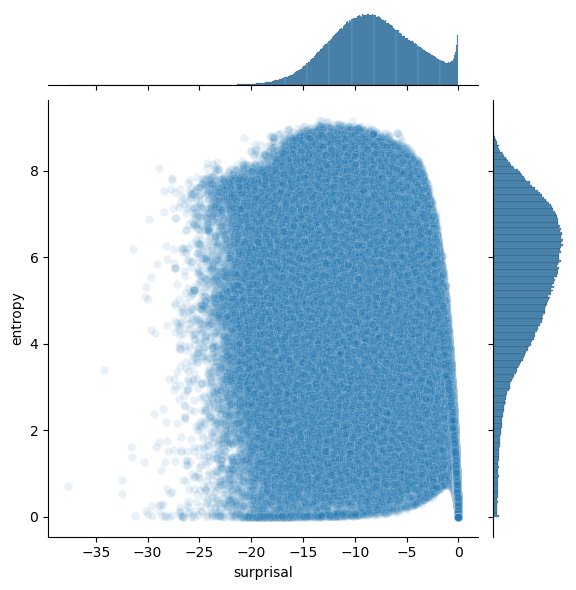

In [24]:
sns.jointplot(data=results_df, x="surprisal", y="entropy", alpha=0.1)

In [25]:
len(matches)

132

In [40]:
merge_count_df = pd.merge(
    results_df[(results_df.entropy.between(4, 5)) & results_df.surprisal.between(-3, 0)].target_word.value_counts().rename("count_low").to_frame(),
    results_df[(results_df.entropy.between(4, 5)) & (results_df.surprisal < -15)].target_word.value_counts().rename("count_high").to_frame(),
    how="outer", left_index=True, right_index=True)
merge_count_df

,count_low,count_high
target_word,,
angle,57.0,76
area,505.0,56
baby,390.0,680
bait,7.0,136
beach,52.0,77
...,...,...
wind,73.0,97
wish,125.0,48
wood,10.0,166


In [41]:
(~merge_count_df.isna()).all(axis=1).sum()

119

In [43]:
if "label" in results_df.columns:
    results_df = results_df.drop(columns=["label"])
results_df.loc[(results_df.entropy.between(4, 5)) & results_df.surprisal.between(-3, 0), "label"] = "low"
results_df.loc[(results_df.entropy.between(4, 5)) & (results_df.surprisal < -15), "label"] = "high"

<Axes: xlabel='label', ylabel='surprisal'>

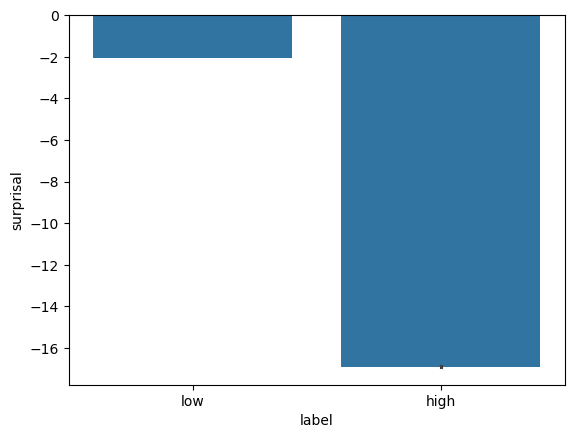

In [45]:
sns.barplot(data=results_df, x="label", y="surprisal")

<Axes: xlabel='label', ylabel='entropy'>

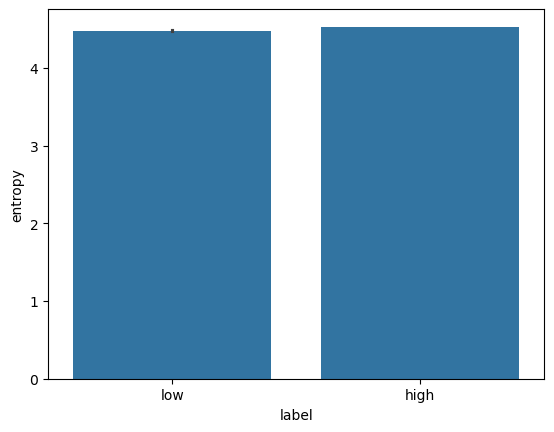

In [46]:
sns.barplot(data=results_df, x="label", y="entropy")

In [47]:
candidate_df = results_df[~results_df.label.isna()].groupby(["target_word", "label"]).sample(10, replace=True)
candidate_df = candidate_df.drop_duplicates("sentence").sort_values(["target_word", "label", "surprisal"])
candidate_df.to_csv(f"candidate_sentences-{scorer.model.name_or_path.replace('/', '-')}.csv")